In [172]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import PIL.Image as Image
import glob

slim = tf.contrib.slim

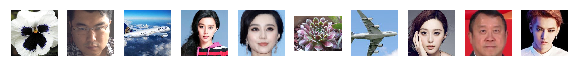

In [173]:
image_path = os.path.expanduser('./data')

file_lists = glob.glob(os.path.join(image_path, '*.jpg'))
reconstruct_key = 'local4'
checkpoint_path = os.path.expanduser('./data/cifar10_train_model1')
file_count = len(file_lists)
plt.figure(num=i, figsize=(file_count,file_count))
plt.axis('off')
plt.xticks([])
plt.yticks([])
for (f,i) in zip(file_lists, range(len(file_lists))):
    img = Image.open(f)
    plt.subplot(file_count,file_count,i+1)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)


In [174]:
NUM_CLASSES = 10
def inference(images, is_training=False, final_point='local4'):
  """Build the CIFAR-10 model.

  Args:
    images: Images returned from distorted_inputs() or inputs().

  Returns:
    Logits.
  """
  end_points = {}
  # We instantiate all variables using tf.get_variable() instead of
  # tf.Variable() in order to share variables across multiple GPU training runs.
  # If we only ran this model on a single GPU, we could simplify this function
  # by replacing all instances of tf.get_variable() with tf.Variable().
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      biases_initializer=tf.constant_initializer(0.1),
                      weights_regularizer=slim.l2_regularizer(4e-5)):
    # conv1
    scope_name = 'conv1'
    with tf.variable_scope(scope_name) as scope:
      net = slim.conv2d(images, 32, [5, 5], stride=2, padding='SAME')
    end_points[scope_name] = net
    
    # 12 x 12 x 32
    # conv2
    scope_name = 'conv2'
    with tf.variable_scope(scope_name) as scope:
      net = slim.conv2d(net, 32, [3, 3], padding='SAME')
      net = slim.conv2d(net, 48, [3, 3], padding='SAME')
      net = slim.conv2d(net, 64, [3, 3], stride=2, padding='SAME')
    end_points[scope_name] = net
    if scope_name==final_point:
        return net, end_points
    
    # 6 x 6 x 64
    scope_name = 'conv3'
    with tf.variable_scope(scope_name) as scope:
      net = slim.conv2d(net, 48, [1, 1], padding='SAME')
      net = slim.conv2d(net, 64, [3, 3], padding='SAME')
    end_points[scope_name] = net
    if scope_name==final_point:
        return net, end_points
    # 6 x 6 x 64

    # pool2
    scope_name = 'conv3'
    net = slim.max_pool2d(net, [2, 2], stride=2, padding='SAME')
    end_points[scope_name] = net
    if scope_name==final_point:
        return net, end_points
    # 3 x 3 x 64
    

    # local3
    scope_name = 'local3'
    with tf.variable_scope(scope_name) as scope:
      net = slim.conv2d(net, 128, [3, 3], padding='VALID')
    end_points[scope_name] = net
    if scope_name==final_point:
        return net, end_points

    # local4
    scope_name = 'local4'
    with tf.variable_scope(scope_name) as scope:
      net = slim.conv2d(net, 128, [1, 1], padding='SAME')
    end_points[scope_name] = net
    if scope_name==final_point:
        return net, end_points

    scope_name = 'softmax_linear'
    with tf.variable_scope(scope_name) as scope:
      softmax_linear = slim.conv2d(net, NUM_CLASSES, [1, 1], padding='SAME',
          activation_fn=None)
      softmax_linear = tf.squeeze(softmax_linear)
    end_points[scope_name] = softmax_linear


    return softmax_linear, end_points

In [175]:
tf.reset_default_graph()
learning_rate = tf.placeholder(tf.float32)
input_jpeg = tf.placeholder(tf.string)
image = tf.image.decode_jpeg(input_jpeg, channels=3)
image = tf.cast(image, tf.float32)

image = tf.image.per_image_standardization(image)
images = tf.expand_dims(image, 0)
images = tf.image.resize_images(images, [24, 24])

logits, end_points_rec = inference(images, final_point=reconstruct_key)

In [176]:
init_op = tf.global_variables_initializer()
sess_config=tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(config=sess_config)
sess.run(init_op)

In [177]:
variable_averages = tf.train.ExponentialMovingAverage(0.9999)
variables_to_restore = variable_averages.variables_to_restore()
for key in variables_to_restore.keys():
    if key.startswith('reconstruct') or key.startswith('beta'):
        variables_to_restore.pop(key)
saver = tf.train.Saver(variables_to_restore, allow_empty=True)

checkpoint = tf.train.latest_checkpoint(checkpoint_path)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from /tmp/cifar10_train_model1/model.ckpt-100000


In [178]:
feature_vectors = []
for file_name in file_lists:
    with open(file_name) as f:
        file_content = f.read()
    feature = sess.run(logits, feed_dict={input_jpeg:file_content}).squeeze()
    feature_vectors.append(feature)
feature_vectors = np.stack(feature_vectors, axis=0)

In [179]:
distance_euclidean = 2*np.sum(
              feature_vectors**2, 
              axis=1) \
    - 2*np.dot(
              feature_vectors, 
              feature_vectors.T)


features_norm = feature_vectors / np.linalg.norm(feature_vectors,axis=1)[:, np.newaxis]
distance_cosin = np.dot(features_norm, features_norm.T)

[0 3 7 1 4 9 5 2 8 6]
[1 7 3 0 4 9 5 2 8 6]
[2 0 7 3 1 4 9 5 8 6]
[3 7 0 1 4 9 5 2 8 6]
[4 7 3 0 9 1 5 8 2 6]
[5 1 7 0 3 4 9 2 8 6]
[6 0 1 7 3 4 5 2 9 8]
[7 3 1 0 4 9 5 2 8 6]
[0 4 7 3 9 8 1 5 2 6]
[7 4 3 9 1 0 5 8 2 6]


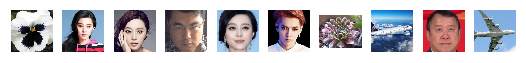

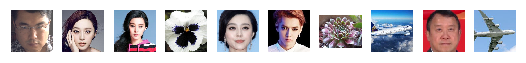

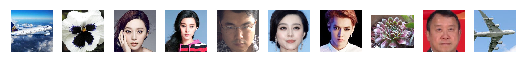

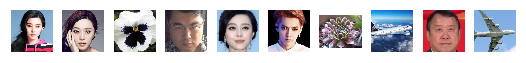

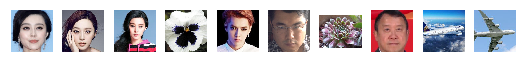

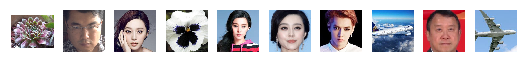

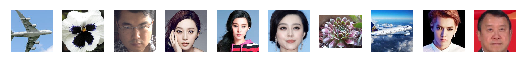

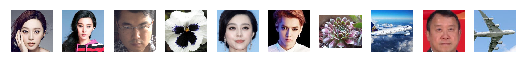

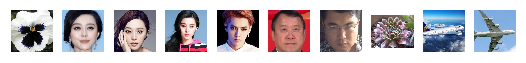

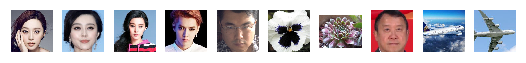

In [180]:
for pattern_index in range(len(file_lists)):
  #for i in range(len(feature_vectors)):
  #    features_norm[i,:] = feature_vectors[i,:]/np.linalg.norm(feature_vectors,axis=1)[i]
  
  #pattern = feature_vectors[pattern_index]
  
  #distance_euclidean = np.mean((feature_vectors - pattern)**2,axis=1)
  #distance_cosin = np.matmul(features_norm, pattern)
  
  order_euclidean = np.argsort(distance_euclidean[pattern_index])
  order_cosin = np.argsort(distance_cosin[pattern_index])[::-1]
  
  order = order_euclidean
  plt_img = Image.open(file_lists[pattern_index])
  plt.figure(num=pattern_index, figsize=(10,10))
  plt.subplot(8,8,1)
  plt.axis('off')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(plt_img)
  print(order)
  for index, i in zip(order, range(len(order))):
      plt_img = Image.open(file_lists[index])
      plt.subplot(11,11,i+2)
      plt.axis('off')
      plt.xticks([])
      plt.yticks([])
      plt.imshow(plt_img)